In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import qutip
from CoupledQuantumSystems.drive import *
from scipy.optimize import minimize
from CoupledQuantumSystems.IFQ import gfIFQ
from CoupledQuantumSystems.evo import ODEsolve_and_post_process
import os, pickle

In [2]:
EJ = 4
EC = EJ/2
EL = EJ/30

qbt = gfIFQ(EJ = EJ,EC = EC, EL = EL, flux = 0,truncated_dim=20)
e_ops = [qutip.basis(qbt.truncated_dim, i)*qutip.basis(qbt.truncated_dim, i).dag() for i in range(10)]

state_0_dressed = qutip.basis(qbt.truncated_dim, 0)
state_1_dressed = qutip.basis(qbt.truncated_dim, 2)
state_plus_X_dressed = (state_0_dressed +  state_1_dressed).unit()
state_minus_X_dressed = (state_0_dressed - state_1_dressed).unit()
state_plus_Y_dressed = (state_0_dressed + 1j * state_1_dressed).unit()
state_minus_Y_dressed = (state_0_dressed - 1j * state_1_dressed).unit()

initial_states  = [
                state_0_dressed,
                state_1_dressed,
                state_plus_X_dressed,
                state_minus_X_dressed,
                state_plus_Y_dressed,
                state_minus_Y_dressed
                ]

e_ops = [qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(qbt.truncated_dim)]

def truncate_to_computational_and_renormaize(state,i,j):
    if state.isket:
        state = qutip.ket2dm(state)
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    dm = dm/dm.tr()
    return dm

def truncate_to_computational_without_renormaize(state,i,j):
    if state.isket:
        state = qutip.ket2dm(state)
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    return dm


zero = qutip.basis(2, 0)
one = qutip.basis(2, 1)
states_ideal  = [zero,
                one,
                (zero +  one).unit(),
                (zero - one).unit(),
                (zero + 1j * one).unit(),
                (zero - 1j *one).unit()]

states_ideal_after_gate = []
for state in states_ideal:
    states_ideal_after_gate.append(qutip.qip.operations.x_gate() * state)

def calc_average_fidelity_with_phase(phase,dms,states_ideal_after_gate):
    gate = qutip.qip.operations.phasegate(phase)
    fid=[]
    for dm,ket_ideal in zip(dms,states_ideal_after_gate):
        fid.append(qutip.fidelity(gate*dm*gate.dag(), ket_ideal))
    return 1-sum(fid)/len(fid)


detuning_arr = np.linspace(0.1,0.4,61)
t_duration_arr = np.linspace(50,125,11)

In [4]:
fidelity_arr_coherent = np.zeros(shape = (len(detuning_arr),len(t_duration_arr)))
leak_to_e_arr_coherent = np.zeros(shape = (len(detuning_arr),len(t_duration_arr)))
additional_leakage_arr_coherent = np.zeros(shape = (len(detuning_arr),len(t_duration_arr)))
def get_e_pop_j(state, j):
    return qutip.expect(qutip.ket2dm(qutip.basis(qbt.truncated_dim,j)), state)


# fig,axes = plt.subplots(len(detuning_arr),len(t_duration_arr),figsize = (10,48))

for i,detuning in enumerate(detuning_arr):
    for j, t_duration in enumerate(t_duration_arr):
        filename = f'json_files/nevergrad_optimized_gf_raman_{detuning}_{t_duration}.json'

        optimization_results = json.load(open(filename))
        
        detuning = optimization_results['detuning']
        t_duration = optimization_results['t_duration']
        best_amp1 = optimization_results['best_amp1']
        best_amp2 = optimization_results['best_amp2']

        tlist = np.linspace(0,t_duration, 101)
    
        dir = 'evo_results'
        if not os.path.exists(dir):
            os.makedirs(dir)
        pickle_filename = f'{dir}/coherent_evo_results_{detuning}_{t_duration}.pkl'
        if os.path.exists(pickle_filename):
            with open(pickle_filename, 'rb') as f:
                results = pickle.load(f)
        else:
            results =  [ODEsolve_and_post_process(
                y0=initial_states[i],
                tlist=tlist,
                static_hamiltonian=qbt.diag_hamiltonian,
                drive_terms=qbt.get_Raman_DRAG_drive_terms(
                            i = 0,
                            j = 3,
                            k = 2,
                            detuning1=detuning,
                            detuning2 = detuning,
                            t_duration=t_duration,
                            shape='sin^2',
                            amp_scaling_factor = 1,
                            amp1_scaling_factor = best_amp1,
                            amp2_scaling_factor = best_amp2,
                            amp1_correction_scaling_factor = 0,
                            amp2_correction_scaling_factor = 0,
                        ),
                c_ops=None,
                e_ops=e_ops,
                print_progress=False
                ) for i in range(len(initial_states))]

            with open(pickle_filename, 'wb') as f:
                pickle.dump(results, f)
        dms = [truncate_to_computational_and_renormaize(result.states[-1], 0,2) for result in results]
        def objective_function(phase):
            return calc_average_fidelity_with_phase(phase[0], dms, states_ideal_after_gate)
        opt_result = minimize(objective_function,x0=  [0],bounds = [(0, 2*np.pi)], method="Powell")
#         for exp_idx in range(len(e_ops))[:10]:
#             axes[i,j].plot(tlist, results[0].expect[exp_idx],label= f"|{exp_idx}>")
#         axes[i,j].set_title(rf'''$\Delta=${detuning:.2f}$\times 2\pi$ $GHz$
# $T_{{gate}}=${int(t_duration)}ns
# $\mathcal{{F}}=${opt_result.fun:.1e}''')
#         axes[i,j].set_yscale('log')
#         axes[i,j].set_ylim(1e-8,1e1)
        print('done one')

        fidelity_arr_coherent[i,j] = opt_result.fun
        leakage_to_list = []
        for l in range(len(e_ops)):
            leakage_to_list.append( [get_e_pop_j(result.states[-1], l) for result in results])
        leak_to_e_arr_coherent[i,j] = np.mean(leakage_to_list[1])
        additional_leakage_arr_coherent[i,j]= np.sum(np.abs(np.array(leakage_to_list)))/len(results)- np.mean(leakage_to_list[1]) - np.mean(leakage_to_list[0]) - np.mean(leakage_to_list[2])

# plt.tight_layout()
# plt.show()

# # plt.subplots_adjust(top=0.9)  # Adjust the top to make room for titles
# plt.savefig('Raman_coherent.pdf')

done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
d

A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
 /tmp/ipykernel_454354/1322312118.py: 51

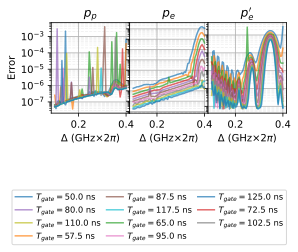

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

l = 0.15
w = 0.28
b = 0.3
t = 0.9
fig = plt.figure(figsize=(3.9, 2.1)) 
gs0 = fig.add_gridspec(nrows=1, ncols=1,left=l, right=l+w,bottom=b,top = t)
gs1 = fig.add_gridspec(nrows=1, ncols=1,left=l+w, right=l+w*2,bottom=b,top = t)
gs2 = fig.add_gridspec(nrows=1, ncols=1,left=l+w*2, right=l+w*3,bottom=b,top = t)

axs = [fig.add_subplot(gs0[0]),  fig.add_subplot(gs1[0]),  fig.add_subplot(gs2[0])]
# markers = ['D','D','o','o','d']
for j,title,data_arr in zip([0,1,2],[r"$p_p$", r"$p_e$", r"$p_e'$"], [fidelity_arr_coherent,leak_to_e_arr_coherent, additional_leakage_arr_coherent]):
    ax = axs[j]
    for i in range(len(t_duration_arr)):
        ax.plot(detuning_arr, data_arr.T[i], label=rf"$T_{{gate}}={t_duration_arr[i]}$ ns",alpha=0.7)
    ax.set_yscale('log')
    # ax.set_xticks([50, 100, 150, 200])
    # ax.set_xlim(40,220)
    # ax.set_ylim(1e-5,1e-2)
    ax.set_xlabel(r"$\Delta$ (GHz$\times2\pi$)")
    ax.set_title(title)

    # Major and minor ticks for logarithmic scale
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))  # Set major ticks
    ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=10))  # Set minor ticks

    ax.grid(which='major', linestyle='-')  # Solid grid lines for major ticks
    ax.grid(which='minor', linestyle='--',alpha=0.2)  # Dashed grid lines for minor ticks
axs[0].set_ylabel('Error')
axs[1].set_ylabel('')
axs[1].set_yticklabels([])
axs[2].set_ylabel('')
axs[2].set_yticklabels([])

handles, labels = axs[0].get_legend_handles_labels()

ncols = 3  # Adjust based on desired layout
nrows = (len(handles) + ncols - 1) // ncols  # Calculate rows dynamically

# Pad to ensure a full grid for reshaping
while len(handles) < ncols * nrows:
    handles.append(None)
    labels.append("")

handles_ordered = np.array(handles).reshape(3, 4).T.flatten().tolist()
labels_ordered = np.array(labels).reshape(3, 4).T.flatten().tolist()

fig.legend(handles_ordered, 
           labels_ordered, 
           loc='lower center', 
           ncol=3, 
           bbox_to_anchor=(0.5, -0.6),
           columnspacing=0.7,        # Reduce space between columns
            handletextpad=0.5,        # Reduce space between markers and text
            fontsize='small',
    )

fig.savefig('raman_coherent_results.pdf')

In [15]:
temp_in_mK = 20
Q_cap = 1e5
one_over_f_flux_noise_amplitude = 1e-6

T1_cops = qbt.get_T1_c_ops(temp_in_mK,
                        Q_cap,
                        one_over_f_flux_noise_amplitude) 
Tphi_cops = qbt.get_Tphi_c_ops(one_over_f_flux_noise_amplitude)

c_ops =T1_cops + Tphi_cops


fidelity_arr = np.zeros(shape = (len(detuning_arr),len(t_duration_arr)))
leak_to_e_arr = np.zeros(shape = (len(detuning_arr),len(t_duration_arr)))
additional_leakage_arr = np.zeros(shape = (len(detuning_arr),len(t_duration_arr)))
def get_e_pop_j(state, j):
    return qutip.expect(qutip.ket2dm(qutip.basis(qbt.truncated_dim,j)), state)

# fig,axes = plt.subplots(len(detuning_arr),len(t_duration_arr),figsize = (10,48))

for i,detuning in enumerate(detuning_arr):
    for j, t_duration in enumerate(t_duration_arr):
        filename = f'json_files/nevergrad_optimized_gf_raman_{detuning}_{t_duration}.json'

        optimization_results = json.load(open(filename))
        
        detuning = optimization_results['detuning']
        t_duration = optimization_results['t_duration']
        best_amp1 = optimization_results['best_amp1']
        best_amp2 = optimization_results['best_amp2']

        tlist = np.linspace(0,t_duration, 101)
        dir = 'evo_results'
        if not os.path.exists(dir):
            os.makedirs(dir)
        pickle_filename = f'{dir}/decay_evo_results_{detuning}_{t_duration}.pkl'
        if os.path.exists(pickle_filename):
            with open(pickle_filename, 'rb') as f:
                results = pickle.load(f)
        else:
            results =  qbt.run_qutip_mesolve_parrallel(
                initial_states,
                tlist,
                drive_terms= qbt.get_Raman_DRAG_drive_terms(
                            i = 0,
                            j = 3,
                            k = 2,
                            detuning1=detuning,
                            detuning2 = detuning,
                            t_duration=t_duration,
                            shape='sin^2',
                            amp_scaling_factor = 1,
                            amp1_scaling_factor = best_amp1,
                            amp2_scaling_factor = best_amp2,
                            amp1_correction_scaling_factor = 0,
                            amp2_correction_scaling_factor = 0,
                        ),
                c_ops=c_ops,
                e_ops=e_ops,
                post_processing=None,
            )
            # Store the results to a pickle file
            with open(pickle_filename, 'wb') as f:
                pickle.dump(results, f)
        dms = [truncate_to_computational_and_renormaize(result.states[-1], 0,2) for result in results]
        def objective_function(phase):
            return calc_average_fidelity_with_phase(phase[0], dms, states_ideal_after_gate)
        opt_result = minimize(objective_function,x0=  [0],bounds = [(0, 2*np.pi)], method="Powell")
#         for exp_idx in range(len(e_ops))[:10]:
#             axes[i,j].plot(tlist, results[0].expect[exp_idx],label= f"|{exp_idx}>")
#         axes[i,j].set_title(rf'''$\Delta=${detuning:.2f}$\times 2\pi$ $GHz$
# $T_{{gate}}=${int(t_duration)}ns
# $\mathcal{{F}}=${opt_result.fun:.1e}''')
#         axes[i,j].set_yscale('log')
#         axes[i,j].set_ylim(1e-8,1e1)
        print('done one')

        fidelity_arr[i,j] = opt_result.fun
        leakage_to_list = []
        for l in range(len(e_ops)):
            leakage_to_list.append( [get_e_pop_j(result.states[-1], l) for result in results])
        leak_to_e_arr[i,j] = np.mean(leakage_to_list[1])
        additional_leakage_arr[i,j]= np.sum(np.abs(np.array(leakage_to_list)))/len(results)- np.mean(leakage_to_list[1]) - np.mean(leakage_to_list[0]) - np.mean(leakage_to_list[2])
        

# plt.tight_layout()

# # plt.subplots_adjust(top=0.9)  # Adjust the top to make room for titles
# plt.savefig('Raman_with_decay.pdf')

# plt.show()


 /home/kai/miniconda3/envs/dynamiqs/lib/python3.10/site-packages/CoupledQuantumSystems/IFQ.py: 63

done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
done one
d

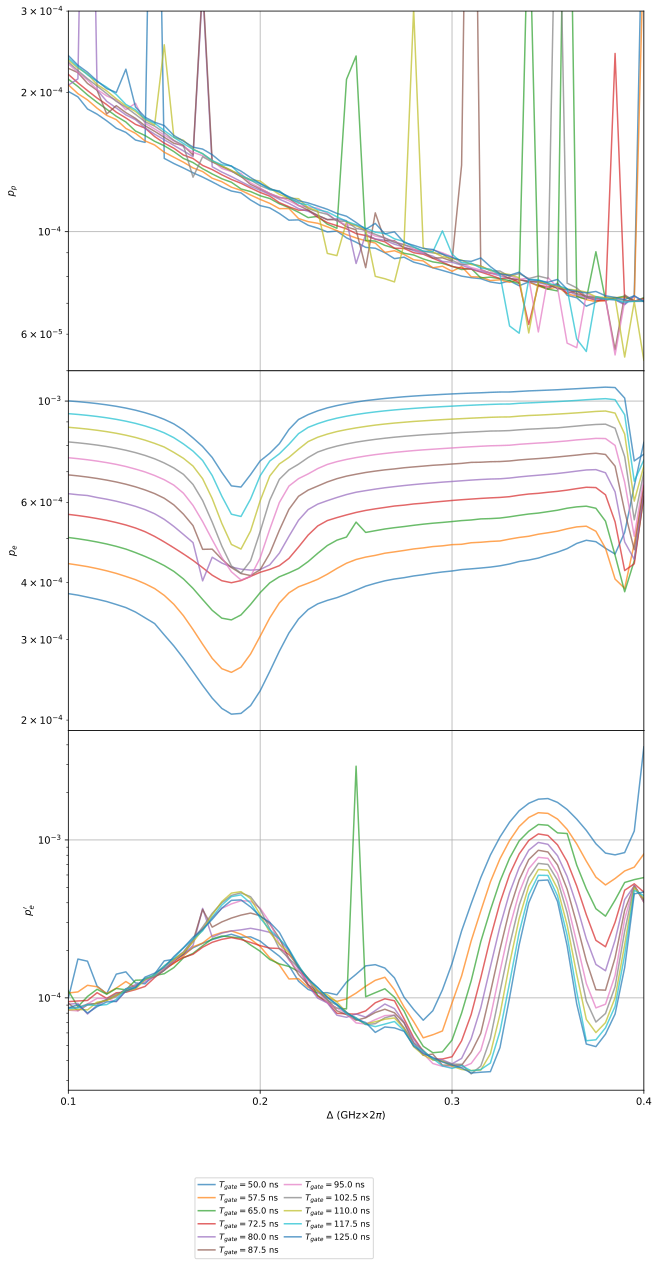

In [29]:
l = 0.2
w = 0.8
b = 0.1
h = 0.25  # Height for each subplot
fig = plt.figure(figsize=(10, 20))  # Adjusted figure size for vertical layout

# Create three vertically stacked subplots
gs0 = fig.add_gridspec(nrows=1, ncols=1, left=l, right=l+w, bottom=b+h*2, top=b+h*3)
gs1 = fig.add_gridspec(nrows=1, ncols=1, left=l, right=l+w, bottom=b+h, top=b+h*2)
gs2 = fig.add_gridspec(nrows=1, ncols=1, left=l, right=l+w, bottom=b, top=b+h)

axs = [fig.add_subplot(gs0[0]), fig.add_subplot(gs1[0]), fig.add_subplot(gs2[0])]

# Plot data in each subplot
for j, (title, data_arr) in enumerate(zip([r"$p_p$", r"$p_e$", r"$p_e'$"], 
                                        [fidelity_arr, leak_to_e_arr, additional_leakage_arr])):
    ax = axs[j]
    for i in range(len(t_duration_arr)):
        ax.plot(detuning_arr, data_arr.T[i], 
                label=rf"$T_{{gate}}={t_duration_arr[i]}$ ns", 
                alpha=0.7)
    ax.set_yscale('log')
    ax.set_ylabel(title)
    ax.grid(which='major', linestyle='-')
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=3))
    
    # Remove x-axis labels and ticks for top two plots
    if j < 2:
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Set x-label only for bottom plot
axs[2].set_xlabel(r"$\Delta$ (GHz$\times2\pi$)")

# Set consistent x-ticks across all plots
xticks = [0.1, 0.2, 0.3, 0.4]
for ax in axs:
    ax.set_xticks(xticks)
    ax.set_xlim(min(xticks), max(xticks))
# axs[2].set_ylim(4e-5,3e-4)
# axs[1].set_ylim(1e-4,1e-3)
axs[0].set_ylim(5e-5,3e-4)
# Add legend below the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels,
          loc='lower center',
          ncol=2,
          bbox_to_anchor=(0.5, -0.02),
          columnspacing=0.7,
          handletextpad=0.5,
          fontsize='small')

fig.savefig('raman_comprehensive_new_results_vertical.pdf', bbox_inches='tight')

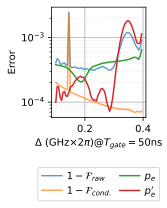

In [13]:
# A plot only for t_duration = 50ns, with new fidelity definitions
raw_fidelity_arr = np.zeros(shape = len(detuning_arr))
leakage_to_e_arr = np.zeros(shape = len(detuning_arr))
additional_leakage_arr = np.zeros(shape = len(detuning_arr))
conditional_computational_fidelity_arr = np.zeros(shape = len(detuning_arr))

# First, do the evolution
for i,detuning in enumerate(detuning_arr):
    j = 0
    t_duration = t_duration_arr[j]
    filename = f'json_files/nevergrad_optimized_gf_raman_{detuning}_{t_duration}.json'
    optimization_results = json.load(open(filename))
    detuning = optimization_results['detuning']
    t_duration = optimization_results['t_duration']
    best_amp1 = optimization_results['best_amp1']
    best_amp2 = optimization_results['best_amp2']

    tlist = np.linspace(0,t_duration_arr[j], 101)
    dir = 'evo_results'
    if not os.path.exists(dir):
        os.makedirs(dir)
    pickle_filename = f'{dir}/decay_evo_results_{detuning}_{t_duration}.pkl'
    if os.path.exists(pickle_filename):
        with open(pickle_filename, 'rb') as f:
            results = pickle.load(f)
    else:
        results = qbt.run_qutip_mesolve_parrallel(
            initial_states,
            tlist,
            drive_terms= qbt.get_Raman_DRAG_drive_terms(
                            i = 0,
                            j = 3,
                            k = 2,
                            detuning1=detuning,
                            detuning2 = detuning,
                            t_duration=t_duration,
                            shape='sin^2',
                            amp_scaling_factor = 1,
                            amp1_scaling_factor = best_amp1,
                            amp2_scaling_factor = best_amp2,
                            amp1_correction_scaling_factor = 0,
                            amp2_correction_scaling_factor = 0,
                        ),
            c_ops=c_ops,
            e_ops=e_ops,
            post_processing=None,
        )
        # Store the results to a pickle file
        with open(pickle_filename, 'wb') as f:
            pickle.dump(results, f)
    
    dms = [truncate_to_computational_without_renormaize(result.states[-1], 0,2) for result in results]
    def objective_function(phase):
        return calc_average_fidelity_with_phase(phase[0], dms, states_ideal_after_gate)
    opt_result = minimize(objective_function,x0=  [0],bounds = [(0, 2*np.pi)], method="Powell")
    raw_fidelity_arr[i] = opt_result.fun
    leakage_to_list = []
    for l in range(len(e_ops)):
        leakage_to_list.append( [get_e_pop_j(result.states[-1], l) for result in results])
    leakage_to_e_arr[i] = np.mean(leakage_to_list[1])
    additional_leakage_arr[i]= np.sum(np.abs(np.array(leakage_to_list)))/len(results)- np.mean(leakage_to_list[1]) - np.mean(leakage_to_list[0]) - np.mean(leakage_to_list[2])
    renormalized_dms = [truncate_to_computational_and_renormaize(result.states[-1], 0,2) for result in results]
    def objective_function(phase):
        return calc_average_fidelity_with_phase(phase[0], renormalized_dms, states_ideal_after_gate)
    opt_result = minimize(objective_function,x0=  [0],bounds = [(0, 2*np.pi)], method="Powell")
    conditional_computational_fidelity_arr[i] = opt_result.fun

fig = plt.figure(figsize=(1.7,2))
plt.plot(detuning_arr[:-1], raw_fidelity_arr[:-1],label = r'$1-\mathcal{F}_{{raw}}$',alpha=0.7)
plt.plot(detuning_arr[:-1], conditional_computational_fidelity_arr[:-1],label = r'$1-\mathcal{F}_{{cond.}}$',alpha=0.7)
plt.plot(detuning_arr[:-1], leakage_to_e_arr[:-1],label = r'$p_e$')
plt.plot(detuning_arr[:-1], additional_leakage_arr[:-1],label = r"$p_e'$")

plt.xlabel(r'$\Delta$ (GHz$\times2\pi) @ T_{{gate}}=50$ns')
plt.ylabel(r'Error')
plt.yscale('log')
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle='--',alpha=0.2)
plt.legend(loc='lower center',ncol=2,bbox_to_anchor=(0.5, -0.8),columnspacing=0.7,handletextpad=0.5)
plt.show()

fig.savefig('raman_comprehensive_50ns.pdf', bbox_inches='tight')